#### toy grover search
&nbsp; &nbsp; &nbsp; following Nielsen-Chuang ( chapter 6.1 ) and Hidary ( chapter 8.6 )

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def int2bit( n, k ):
    assert n < 2 ** k
    b = [ 0 if b == '0' else 1 for b in bin( n )[ 2 : ] ]
    b = ( k - len( b ) ) * [ 0 ] + b
    return b # the binary expansion of n, as a list of k bits

In [3]:
def bit2int( b ):
    n = sum( [ bn * 2 ** n for n, bn in enumerate( reversed( b ) ) ] )
    return n

In [4]:
def reflection( q ):
    R = [ cirq.Z.controlled( len( q ) - 1 ).on( * q ) ]
    return R # a gate in a list

In [5]:
def oracle_gates( q, m ): # only the oracle knows m
    b = int2bit( m, len( q ) ) # the bits of m
    Xs = [ cirq.X( qn ) for qn, bn in zip( q, b ) if bn == 0 ]
    R = reflection( q )
    return Xs + R + Xs # gates in a list

In [6]:
def diffusion_gates( q ):
    Hs = [ cirq.H.on_each( q ) ]
    Xs = [ cirq.X.on_each( q ) ]
    R = reflection( q )
    return Hs + Xs + R + Xs + Hs # gates in a list

In [7]:
def grover_circuit( q, oracle, diffuser, size ):
    Hs = [ cirq.H.on_each( q ) ]
    rotations = size * ( oracle + diffuser ) # two reflections make a rotation
    measure = [ cirq.measure( qn, key = str( n ) ) for n, qn in enumerate( q ) ]
    return cirq.Circuit( Hs + rotations + measure )

In [8]:
def simulate( q, program, repetitions ):
    result = cirq.Simulator( ).run( program = program, repetitions = repetitions )
    result = [ result.measurements[ str( n ) ] for n in range( len( q ) ) ]
    return np.array( result ).squeeze( )

In [9]:
def plot( measurement, k ):
    prob = np.zeros( 2 ** k, dtype = 'float' )
    for n in measurement : prob[ n ] += 1 / len( measurement )
    fig, axis = plt.subplots( figsize = ( 14, 5 ), facecolor = 'black' )
    axis.set_facecolor( 'black' )
    axis.tick_params( colors = 'white' )
    axis.set_xlabel( 'measurement', color = 'white', size = '14' )
    axis.set_ylabel( 'probability', color = 'white', size = '14' )
    axis.plot( range( 2 ** k ), prob, color = 'white', marker = '.', linestyle = 'None' )
    plt.show( )

In [10]:
def display( circuit, result, size, m ):
    [ k, repetitions ] = result.shape
    sqrt = int( 3.14 / 4 * 2 ** ( k / 2 ) ) 
    measurement = [ bit2int( result[ : , n ] ) for n in range( repetitions ) ]
    print( 'grover circuit simulation\n' )
    print( f'qubits        { k }' )
    print( f'optimal size  { sqrt } rotations' )
    print( f'actual  size  { size } rotations' )
    print( f'looking for   { m } among the numbers { 0 }, { 1 }, ..., { 2 ** k - 1 }\n' )
    if repetitions < 300 : print( f'measurements\n{ measurement }' )
    if k < 20 : plot( measurement, k )
    if size <  4 : print( f'\ncircuit diagram\n{ circuit }' ) 

grover circuit simulation

qubits        5
optimal size  4 rotations
actual  size  3 rotations
looking for   6 among the numbers 0, 1, ..., 31

measurements
[6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 27, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 27, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 15, 6, 6, 6, 6, 11, 6, 6, 14, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 21, 6, 6, 6, 6, 6, 6, 6, 6, 6]


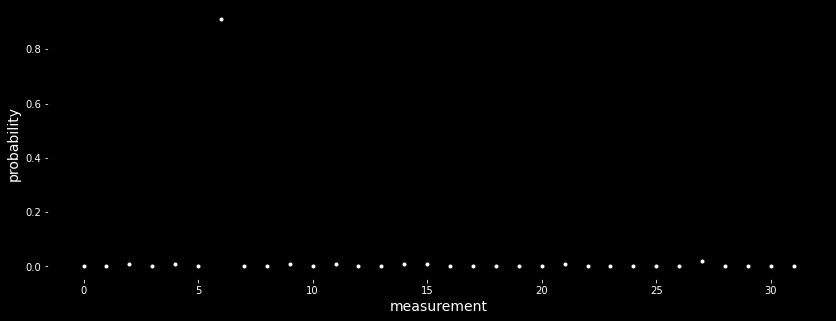


circuit diagram
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('0')───
              │               │               │               │               │               │
1: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('1')───
              │               │               │               │               │               │
2: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('2')───
              │               │               │               │               │               │
3: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('3')───
              │               │               │               │               │               │
4: ───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───M('4')───


In [11]:
m = 6 # the number that we hope to measure at the end of the circuit
k = 5 # the number of qubits in the circuit
size = 3 # the number of rotations in the circuit
repetitions = 100 # the number of circuit simulations

q = cirq.LineQubit.range( k )
oracle = oracle_gates( q, m )
diffuser = diffusion_gates( q )
grover = grover_circuit( q, oracle, diffuser, size )
result = simulate( q, grover, repetitions )
display( grover, result, size, m )

grover circuit simulation

qubits        16
optimal size  200 rotations
actual  size  100 rotations
looking for   11111 among the numbers 0, 1, ..., 65535

measurements
[11111, 26349, 11111, 11111, 25987, 11111, 27806, 11111, 11111, 25942, 11111, 20338, 27012, 11111, 63265, 30598, 36668, 19253, 11111, 64429, 4289, 8537, 56712, 11111, 11111, 11111, 11111, 2241, 55008, 34540, 37763, 27192, 30469, 54271, 50872, 1905, 49253, 53545, 11111, 11111, 2020, 11111, 11111, 49971, 39901, 11111, 18651, 25946, 11111, 37711]


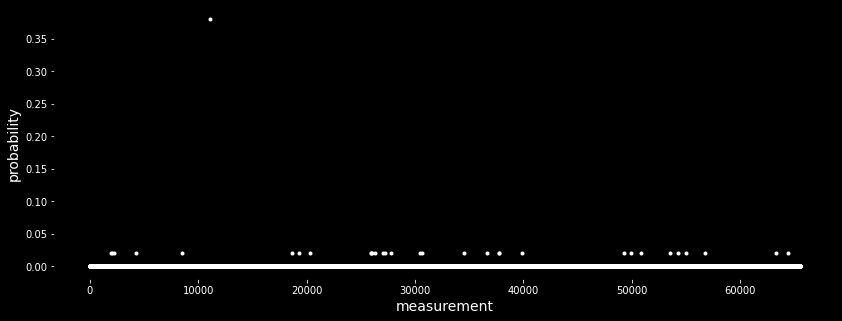

In [12]:
m = 11111
k = 16
size = 100
repetitions = 50

q = cirq.LineQubit.range( k )
oracle = oracle_gates( q, m )
diffuser = diffusion_gates( q )
grover = grover_circuit( q, oracle, diffuser, size )
result = simulate( q, grover, repetitions )
display( grover, result, size, m )